# Курсовая работа по предсказанию цены на недвижимость

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# функцию будем использовать для оценки качества модели
def evaluate_preds(true_values, pred_values):
  print('R2:\t' + str(round(r2(true_values, pred_values), 3)))

  plt.figure(figsize=(8, 8))

  sns.scatterplot(x=pred_values, y=true_values)

  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.title('True vs Predicted values')
  plt.show()

## Загрузка данных

Необходимо скачать датасет и добавить в Google Colab:

Train: https://drive.google.com/file/d/1lAuAk8HPwRtPfdahv7YJL31-sewg-Cuo/view?usp=sharing

Test: https://drive.google.com/file/d/1G7zntIyMwQkZIOv7But8FEnqLXfyHD8b/view?usp=drive_link

Описание датасета:

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
df.shape

(10000, 20)

## Подготовка данных, анализ выбросов



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Найдем пустоты в данных.

In [7]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Количественные признаки: данные площади недвижимости

Выбросим из данных недвижимость размером меньше 15кв.м.

In [8]:
df = df[df['Square'] > 15]

Найдем выбросы в LifeSquare.

In [9]:
df[df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


По цене и количеству комнат видно, что это не правильные значения, и скорее всего они увеличины в 10 раз. Исправим эти данные.

*Т.к. таких данных мало, относительно размера датасета, их также можно было бы просто выкинуть.*

In [10]:
df.loc[df['Square'] > 300, 'Square'] = df.loc[df['Square'] > 300, 'Square'] / 10

In [11]:
df[(df['LifeSquare'] / df['Square']) > 1.2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
357,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
5183,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
5712,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.073757
7010,2307,102,1.0,40.942518,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
8000,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
9229,11602,30,2.0,64.106519,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


По площади Square видно, что часть данных по площади LifeSquare увеличины в 10 или 100 раз.

*Т.к. таких данных мало, относительно размера датасета, их также можно было бы просто выкинуть.*

Сначала исправим преувеличенные данные (выполним дважды, чтобы сперва привести в норму увеличенные на 10, а потом увеличенные на 100).

In [12]:
df.loc[(df['LifeSquare'] / df['Square']) > 4.9, 'LifeSquare'] = df.loc[(df['LifeSquare'] / df['Square']) > 5, 'LifeSquare'] / 10
df.loc[(df['LifeSquare'] / df['Square']) > 4.9, 'LifeSquare'] = df.loc[(df['LifeSquare'] / df['Square']) > 5, 'LifeSquare'] / 10

Посмотрим пропуски в LifeSquare и решим чем их заполнить.

In [13]:
df[df['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114


В большинстве данных площаль Square больше, чем LifeSquare.

In [14]:
(df['Square'] / df['LifeSquare']).mean()

2.1284043435328956

Заменим пустоты LifeSquare на среднее значение для площади Square данной квартиры.

In [15]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df.loc[df['LifeSquare'].isnull(), 'Square'] / (df['Square'] / df['LifeSquare']).mean()

In [16]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,54.043918,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,18.986010,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


Проверим, что избавились от пустот в жилой площади.

In [17]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4789
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Так как у признака Healthcare_1 больше половины значений пустых, то в последствии полностью исключим этот признак.

Найдем выбросы в KitchenSquare.

In [18]:
df['KitchenSquare'].value_counts()

1.0       2450
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        695
7.0        608
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

Мы видим огромные площади, предположительно эти данные также увеличены в 10 и 100 раз.

*Т.к. таких данных мало, относительно размера датасета, их также можно было бы просто выкинуть.*

In [19]:
df[(df['KitchenSquare'] / df['Square']) > 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207


Исправим эти данные, как и в случае с LifeSquare.

In [20]:
df.loc[(df['KitchenSquare'] / df['Square']) > 1, 'KitchenSquare'] = df.loc[(df['KitchenSquare'] / df['Square']) > 1, 'KitchenSquare'] / 10
df.loc[(df['KitchenSquare'] / df['Square']) > 1, 'KitchenSquare'] = df.loc[(df['KitchenSquare'] / df['Square']) > 1, 'KitchenSquare'] / 10

Заменим нулевые значения KitchenSquare средними.

In [21]:
df.loc[(df['KitchenSquare'] == 0, 'KitchenSquare')] = df['KitchenSquare'].median()

### Количественные признаки: этажность, количество комнат и год постройки

Посмотрим возможные значения комнат и найдем выбросы.

In [22]:
df['Rooms'].value_counts()

2.0     3879
1.0     3697
3.0     2232
4.0      150
5.0       18
0.0        7
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [23]:
df[(df['Rooms'] == 0) | (df['Rooms'] >= 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,19.634841,6.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,23.249107,6.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,6.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,38.287578,6.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,6.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389


Заменим эти значения на средние.

In [24]:
df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 10), 'Rooms'] = df['Rooms'].median()

Посмотрим данные в этажности домов.

In [25]:
df['HouseFloor'].value_counts()

17.0     2329
9.0      1389
12.0     1074
5.0      1030
14.0      625
16.0      576
1.0       492
25.0      373
22.0      342
0.0       268
24.0      176
8.0       141
10.0      135
4.0       133
3.0       127
15.0      123
19.0      107
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
39.0        2
48.0        2
47.0        1
38.0        1
36.0        1
29.0        1
44.0        1
31.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

Заменим выбросы в виде 99 и 117 этажей на моду.

In [26]:
df.loc[df['HouseFloor'] == 117, 'HouseFloor'] = df['HouseFloor'].mode()[0]
df.loc[df['HouseFloor'] == 99, 'HouseFloor'] = df['HouseFloor'].mode()[0]

In [27]:
df[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203947,20.768585,6.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
152,12947,53,2.0,56.023342,26.321757,6.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832
159,13146,74,1.0,46.449711,21.823725,6.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148
186,12174,62,1.0,44.954880,21.121400,6.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722
229,15661,45,3.0,81.094922,38.101276,6.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,20.173199,6.0,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139
9931,15686,1,1.0,47.402412,22.271338,6.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224
9940,4711,6,1.0,41.224118,19.368556,6.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104
9950,5383,48,3.0,98.994909,46.511326,6.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446


Удалять данные без этажности дома не очень хорошо, поэтому приравняем этажность дома к этажу, на котором продается квартира + 1, чтобы не была верхней (усредним).

In [28]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor'] + 1

Проверим год постройки.

In [29]:
df['HouseYear'].value_counts()

1977        2643
2017         308
2016         304
2015         299
2014         209
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Видны 2 выброса. Предположим, что 20052011 это либо неизвестная дата с 2005 по 2011, либо дата 2005.20.11. Возьмем значение подходящее под оба условия - 2005

In [30]:
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2005

Заменим оставшееся значение на моду (хотя это также может быть опечаткой 1968).

In [31]:
df.loc[df['HouseYear'] == 4968, 'HouseYear'] = df['HouseYear'].mode()[0]

### Распределение подготовленных признаков

Проверим распределение подготовленных признаков на предмет выбросов.

In [32]:
df_num_features = df[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1']]

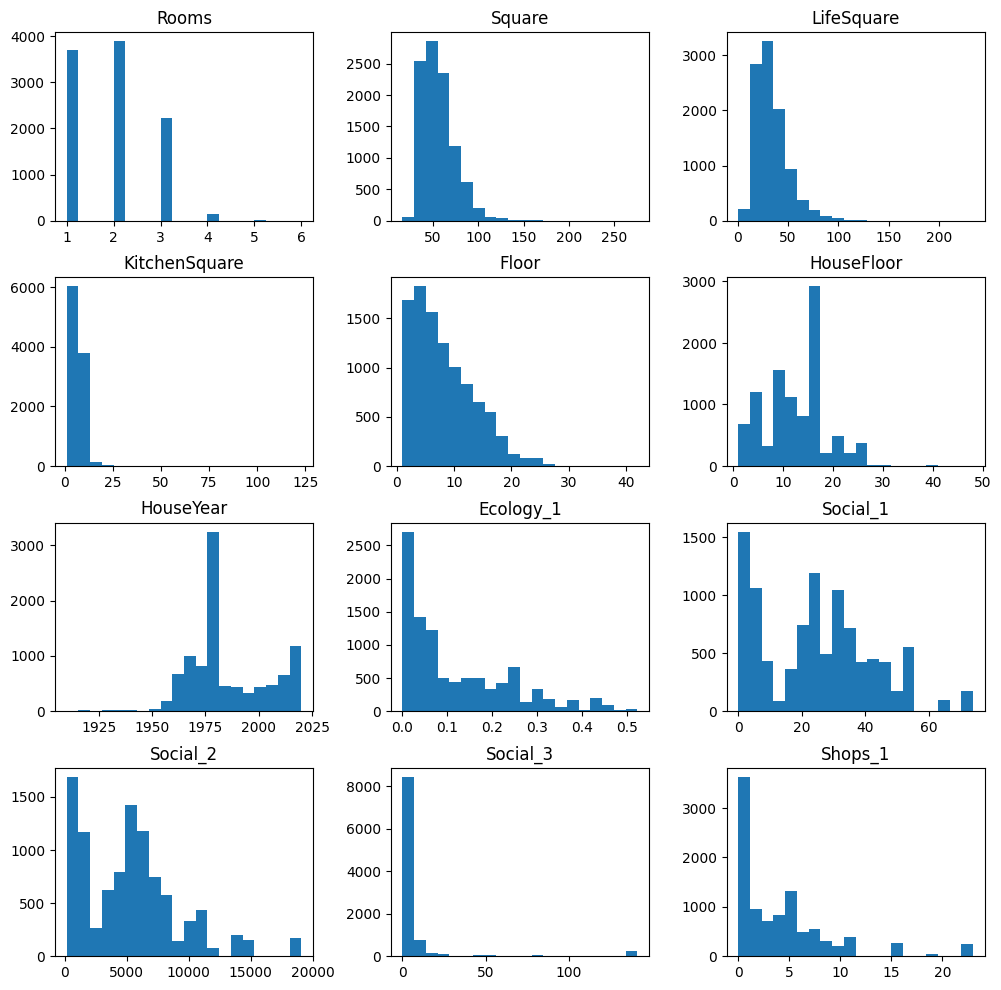

In [33]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False)
plt.show()

Видны выбросы в признаках Square, LifeSquare, KitchenSquare, Floor, HouseFloor и HouseYear, но все значения в рамках возможных, поэтому удалять их не будем.

В параметре Social_3 виден выброс, но мы не знаем как интерпретировать этот рейтинг.

### Категориальные признаки (рейтинги)

In [34]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [35]:
df['Ecology_2'].value_counts()

B    9890
A      97
Name: Ecology_2, dtype: int64

In [36]:
df['Ecology_3'].value_counts()

B    9712
A     275
Name: Ecology_3, dtype: int64

In [37]:
df['Shops_2'].value_counts()

B    9162
A     825
Name: Shops_2, dtype: int64

Приведем A-B-рейтинги к dummy переменным.

In [38]:
pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')

,Ecology_2_A,Ecology_2_B
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
9995,0,1
9996,0,1
9997,0,1
9998,0,1


Добавим dummies для категориальных признаков в наш датасет.

In [39]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2'), pd.get_dummies(df['Ecology_3'], prefix='Ecology_3'), pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,27,3.0,115.027311,54.043918,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,1,0,1,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,1,0,1,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,1,0,1,0,1
3,2352,1,1.0,40.409907,18.986010,1.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,1,0,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,0,1,0,1,0,1


In [40]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [41]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

Создаем 2 переменные с нецелевыми признаками и с целевым, заодно избавимся от лишних колонок категориальных признаков.

In [42]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
                 'Shops_1','Shops_2_A', 'Shops_2_B']

target_name = 'Price'

Перезапишем датафрейм только с выбранными нами признаками в нужном порядке.

In [43]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_A,Ecology_3_B,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Price
0,27,3.0,115.027311,54.043918,10.0,4,10.0,2014,0.075424,0,...,0,1,11,3097,0,0,0,0,1,305018.871089
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,0,...,0,1,30,6207,1,1,0,0,1,177734.553407
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,0,...,0,1,33,5261,0,3,1,0,1,282078.720850
3,1,1.0,40.409907,18.986010,1.0,10,22.0,1977,0.007122,0,...,0,1,1,264,0,0,1,0,1,168106.007630
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,0,...,0,1,33,8667,2,0,6,0,1,343995.102962


### Анализ целевой переменной

Найдем среднюю и медианную значения для цены.

In [44]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()

target_mean, target_median

(214088.18, 192277.32648899368)

Построим график распределения плотности цены и отобразим на нем среднее и медианное значения.

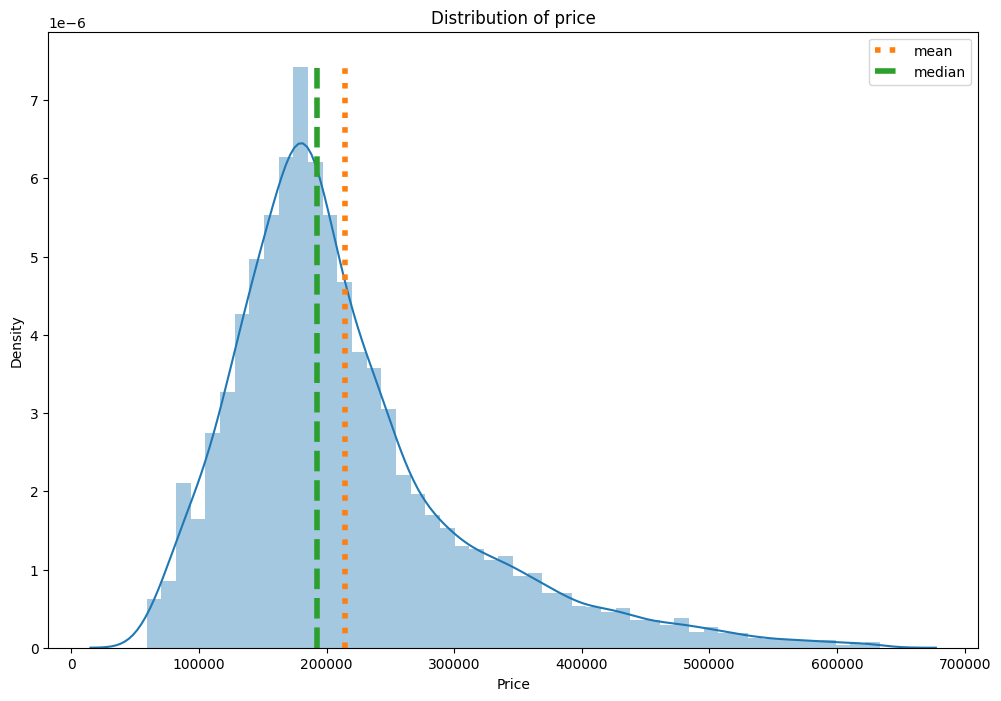

In [45]:
plt.figure(figsize=(12, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.0000075, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

Построим матрицу корелляций.

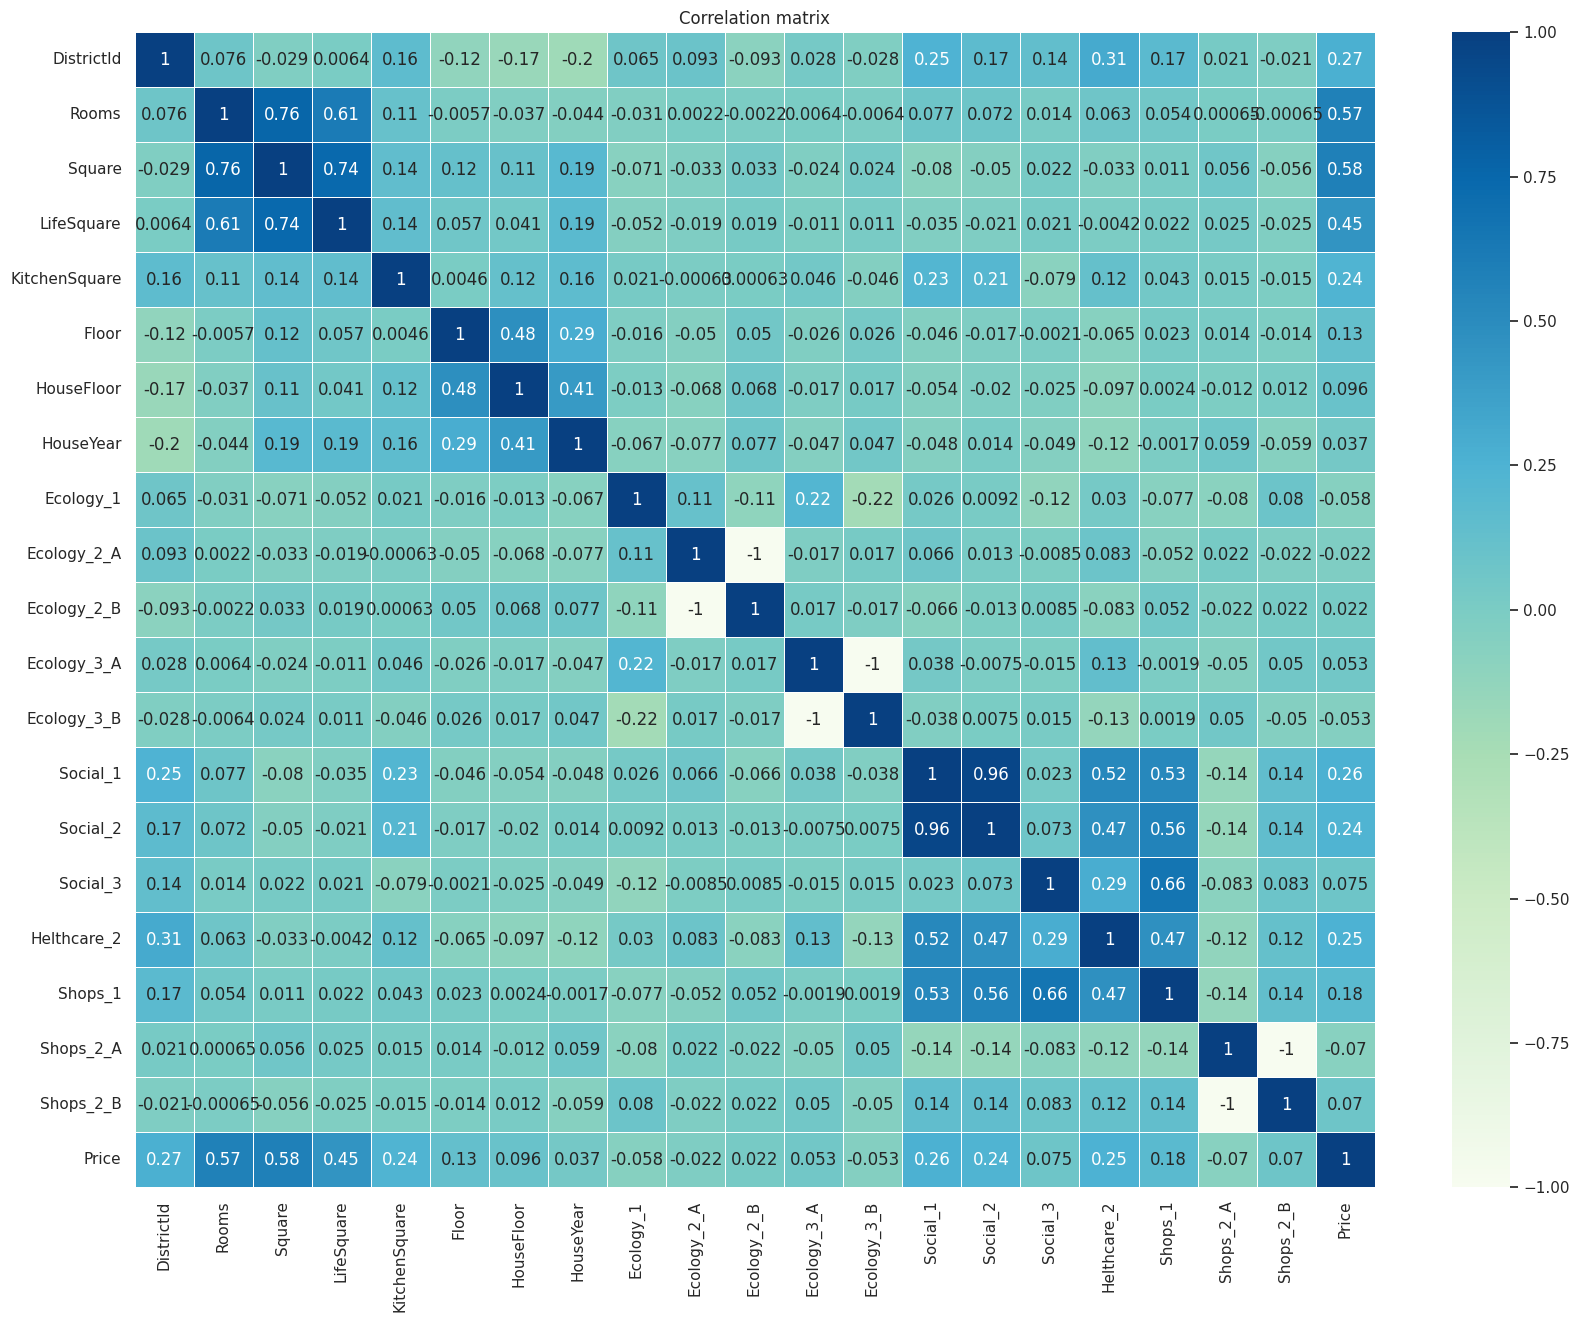

In [46]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidth=0.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из матрицы корреляций видно, что Social_2_B обратно пропорционален Social_3_B, но мы не знаем, что это за рейтинги и значения для полноценного вывода. Social_1 имеет высокую корреляцию с Social_2, предположительно это дополняющие друг друга рейтинги. А также, что рейтинги Social_1, Social_2 и Social_3 достаточно хорошо коррелируют с рейтингами Healthcare_2 и Shops_1.

А также высокая корреляция между площадями квартир.

Наибольшая корелляция цены будет с признаками Rooms и Square, но т.к. признак Rooms очень дискретный в малом диапазоне (1 - 6), то график будет бесполезен, а вот признак Square очень интересен. Построим зависимость Price от Square.

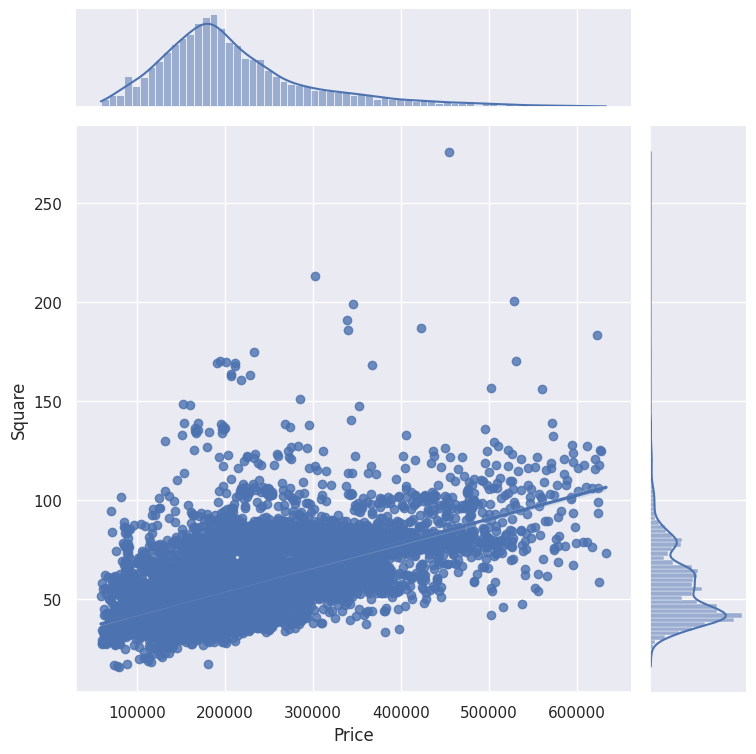

In [47]:
grid = sns.jointplot(x=df['Price'], y=df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

Посмотрим еще на зависимости цены от разных признаков, дополнительно сделаем разбивку на цену меньше/больше медианной.

In [48]:
df['Price over median'] = df['Price'] > target_median
data = df[['Price over median', 'DistrictId', 'Square', 'Rooms', 'Floor', 'HouseYear', 'Ecology_1', 'Social_1', 'Helthcare_2', 'Shops_1', 'Price']]
data.head()

,Price over median,DistrictId,Square,Rooms,Floor,HouseYear,Ecology_1,Social_1,Helthcare_2,Shops_1,Price
0,True,27,115.027311,3.0,4,2014,0.075424,11,0,0,305018.871089
1,False,22,39.832524,1.0,7,1966,0.118537,30,1,0,177734.553407
2,True,1,78.342215,3.0,2,1988,0.025609,33,3,1,282078.720850
3,False,1,40.409907,1.0,10,1977,0.007122,1,0,1,168106.007630
4,True,94,64.285067,2.0,16,1972,0.282798,33,0,6,343995.102962


In [49]:
sns.pairplot(data, hue='Price over median', plot_kws={'alpha': 0.5})

Output hidden; open in https://colab.research.google.com to view.

Кроме площади и экологии особых закономерностей не выявлено.

## Построение модели

### Разбиение на train и test

Разобьем наши данные на тренировочную и тестовую выборку.

In [50]:
x = df[feature_names]
y = df[target_name]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=21)

### Линейная регрессия

Обучим модель Линейной регрессии на тренировочной выборке.

In [52]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

Проверим результат обучения на тренировочных данных с помощью метрики R2.

R2:	0.541


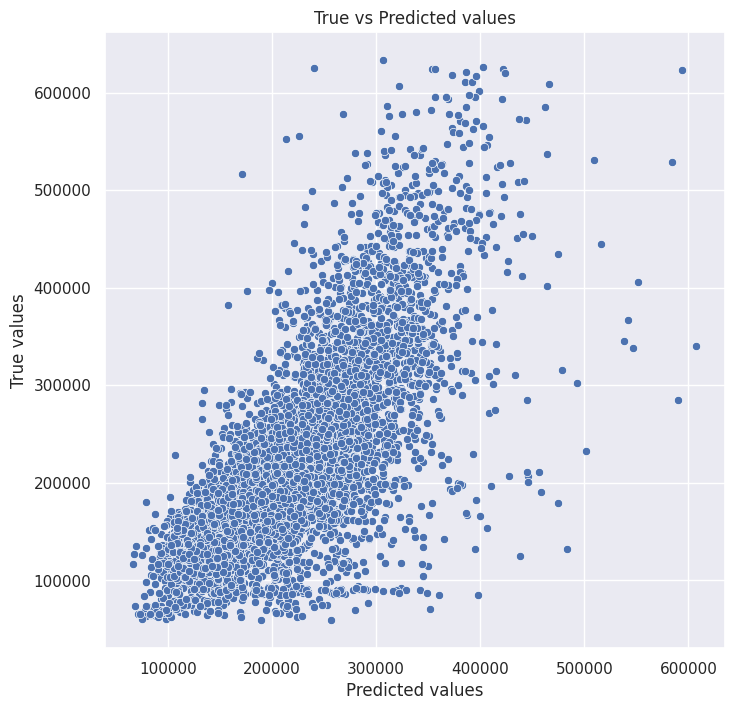

In [53]:
y_train_preds = lr_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

Проверим результат обучения на тестовых данных с помощью метрики R2

R2:	0.521


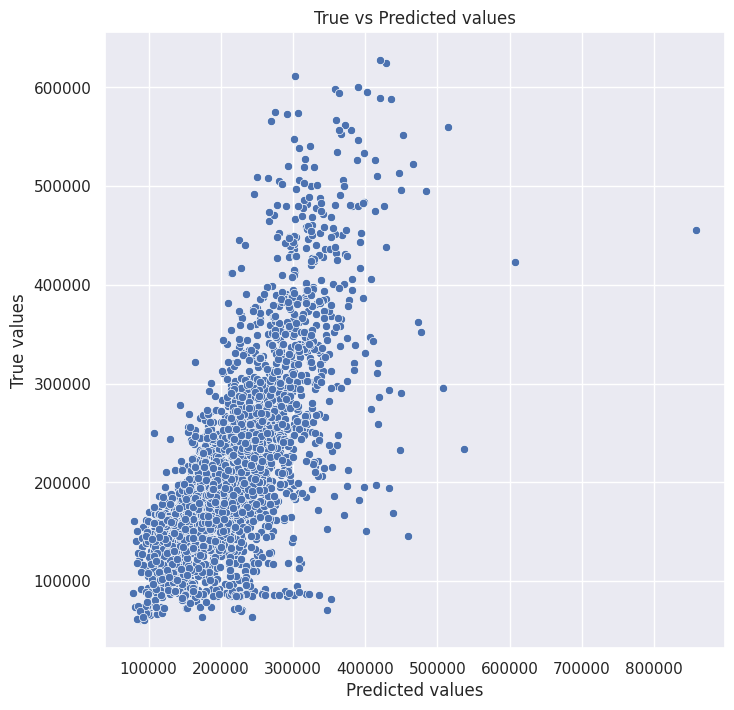

In [54]:
y_test_preds = lr_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

Результаты R2 в виде 0.54 и 0.52 нас не устаивают, попробуем провести нормализацию.

### Нормализация

Т.к. данные у нас разных масштабов, то проведем нормализацию этих данных для лучшей работы моделей.

In [55]:
scaler = MinMaxScaler()
scaler.fit(x_train)

MinMaxScaler()

In [56]:
x_train_std = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_train_std.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B
0,0.504808,0.8,0.351581,0.267077,0.036036,0.073171,0.234043,0.509259,0.077113,0.0,1.0,0.0,1.0,0.337838,0.174993,0.078014,0.500000,0.043478,0.0,1.0
1,0.110577,0.0,0.081985,0.070108,0.000000,0.121951,0.234043,0.601852,0.066408,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
2,0.139423,0.0,0.111116,0.121160,0.036036,0.121951,0.085106,0.500000,0.133483,0.0,1.0,0.0,1.0,0.418919,0.314618,0.028369,0.166667,0.086957,0.0,1.0
3,0.139423,0.0,0.077444,0.084301,0.036036,0.073171,0.085106,0.444444,0.133483,0.0,1.0,0.0,1.0,0.418919,0.314618,0.028369,0.166667,0.086957,0.0,1.0
4,0.177885,0.2,0.170527,0.151082,0.045045,0.073171,0.276596,0.583333,0.244912,0.0,1.0,0.0,1.0,0.378378,0.376368,0.035461,0.166667,0.130435,0.0,1.0


In [57]:
x_test_std = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

Проверим результат обучения на тренировочных данных с помощью метрики R2 после нормализации.

R2:	0.541


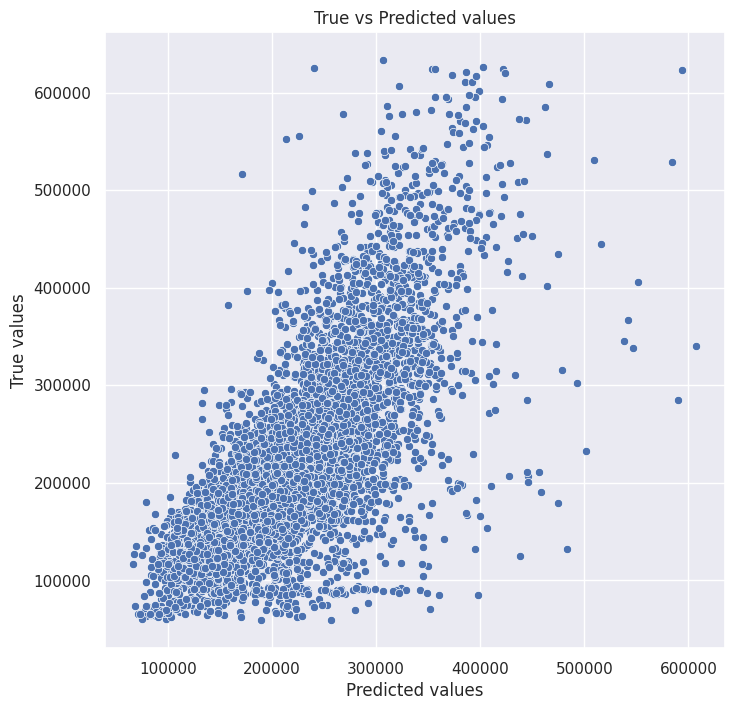

In [58]:
y_train_std_preds = lr_model.predict(x_train_std)
evaluate_preds(y_train, y_train_preds)

Проверим результат обучения на тестовых данных с помощью метрики R2 после нормализации.

R2:	0.521


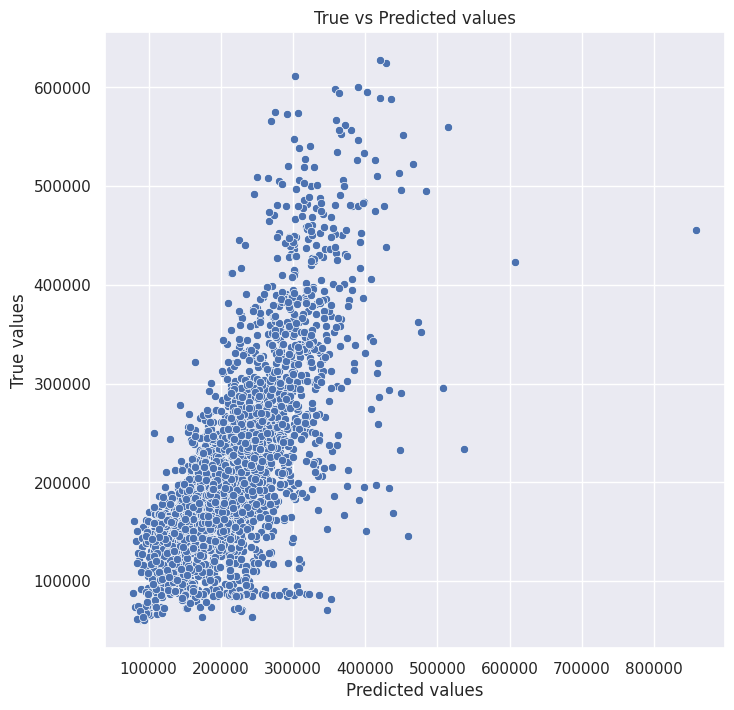

In [59]:
y_test_std_preds = lr_model.predict(x_test_std)
evaluate_preds(y_test, y_test_preds)

Результат не изменился, следовательно необходимо применять другую модель.

### Random Forest

Построим модель с помощью случайного леса

In [60]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

RandomForestRegressor()

Проверим результат обучения на тренировочных данных с помощью метрики R2.

R2:	0.963


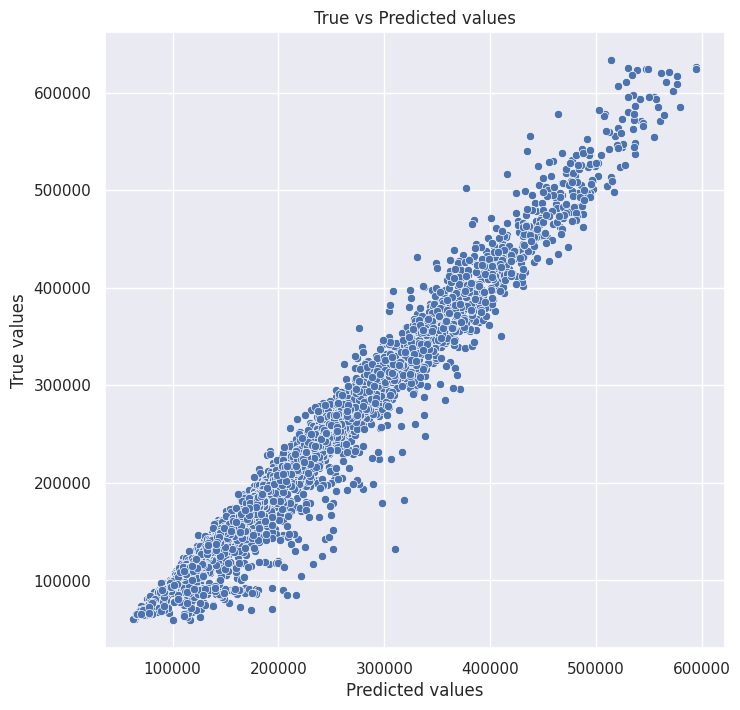

In [61]:
y_train_preds = rf_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

Проверим результат обучения на тестовых данных с помощью метрики R2.

R2:	0.711


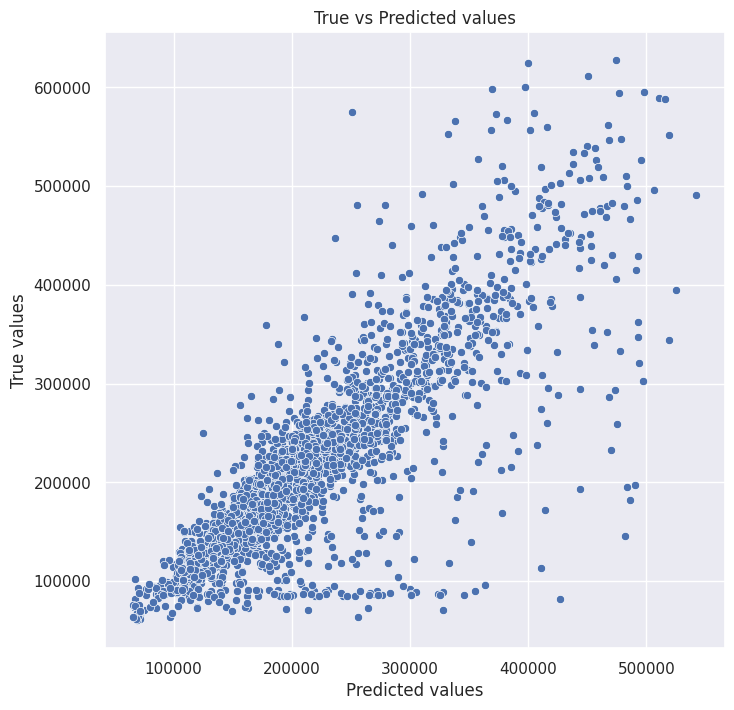

In [62]:
y_test_preds = rf_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

Результат на тренировочных данных получился очень хорошим - 0.96, а вот результат на тестовых хуже - 0.71. Видимо есть эффект переобучения, необходимо попробовать другие параметры модели.

### GridSearchCV

In [63]:
params = {'n_estimators': [50, 100, 150, 200, 300, 400, 500, 600], 'max_depth': [2, 3, 5, 7, 10, 15, 20, 25]}

gs = GridSearchCV(rf_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(x, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7, 10, 15, 20, 25],
                         'n_estimators': [50, 100, 150, 200, 300, 400, 500,
                                          600]},
             scoring='r2')

In [64]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [65]:
gs.best_score_

0.7245166528430008

Построим модель с лучшими параметрами

In [66]:
rf_model = RandomForestRegressor(max_depth= 15, n_estimators=600, random_state=21)
rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=600, random_state=21)

Проверим результат обучения на тренировочных данных с помощью метрики R2.

R2:	0.946


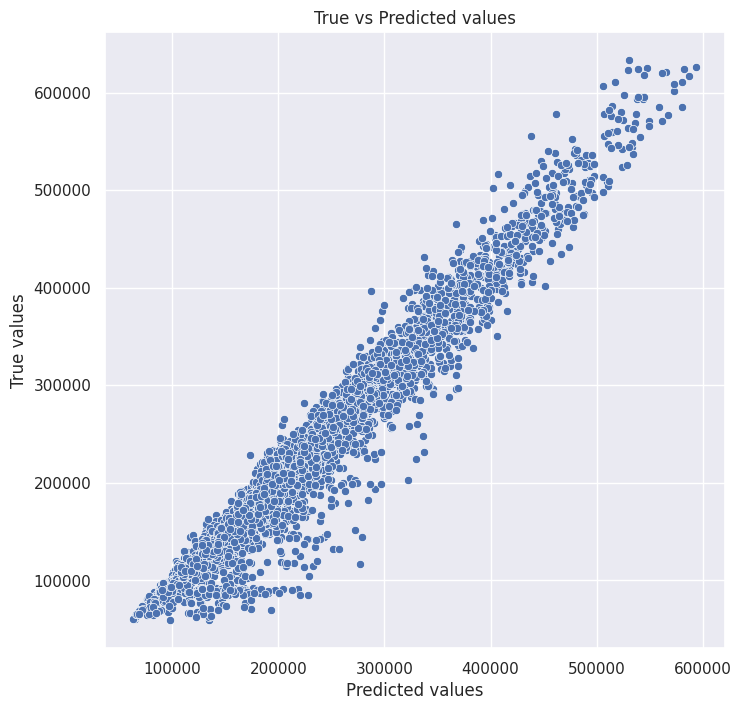

In [67]:
y_train_preds = rf_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

Проверим результат обучения на тестовых данных с помощью метрики R2.

R2:	0.714


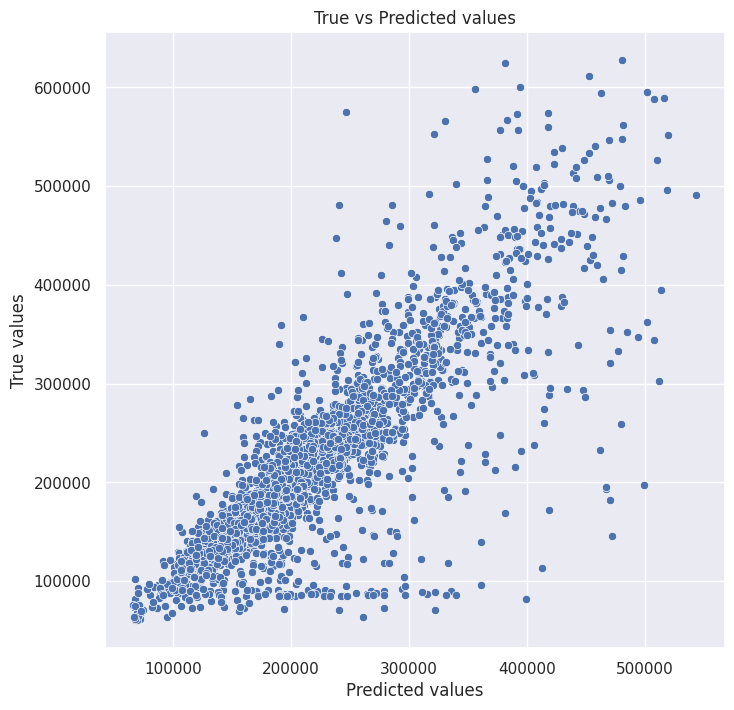

In [68]:
y_test_preds = rf_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

Результат немного улучшился, но не существенно. Считаем этот резальтат наилучшим в 0.714 на тесте.

## Предсказание цены

In [69]:
df2 = pd.read_csv('test.csv')
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### Подготовка данных

Повторим подготовку датасета, как и в случае с тренировочными данными

In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [71]:
df2.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [72]:
len(df2) - df2.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

Заменим пустоты LifeSquare на среднее значение для площади Square данной квартиры. А Healthcare_1 удалим впоследствии.

In [73]:
df2.loc[df2['LifeSquare'].isnull(), 'LifeSquare'] = df2.loc[df2['LifeSquare'].isnull(), 'Square'] / (df2['Square'] / df2['LifeSquare']).mean()

In [74]:
df2_num_features = df2[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1']]

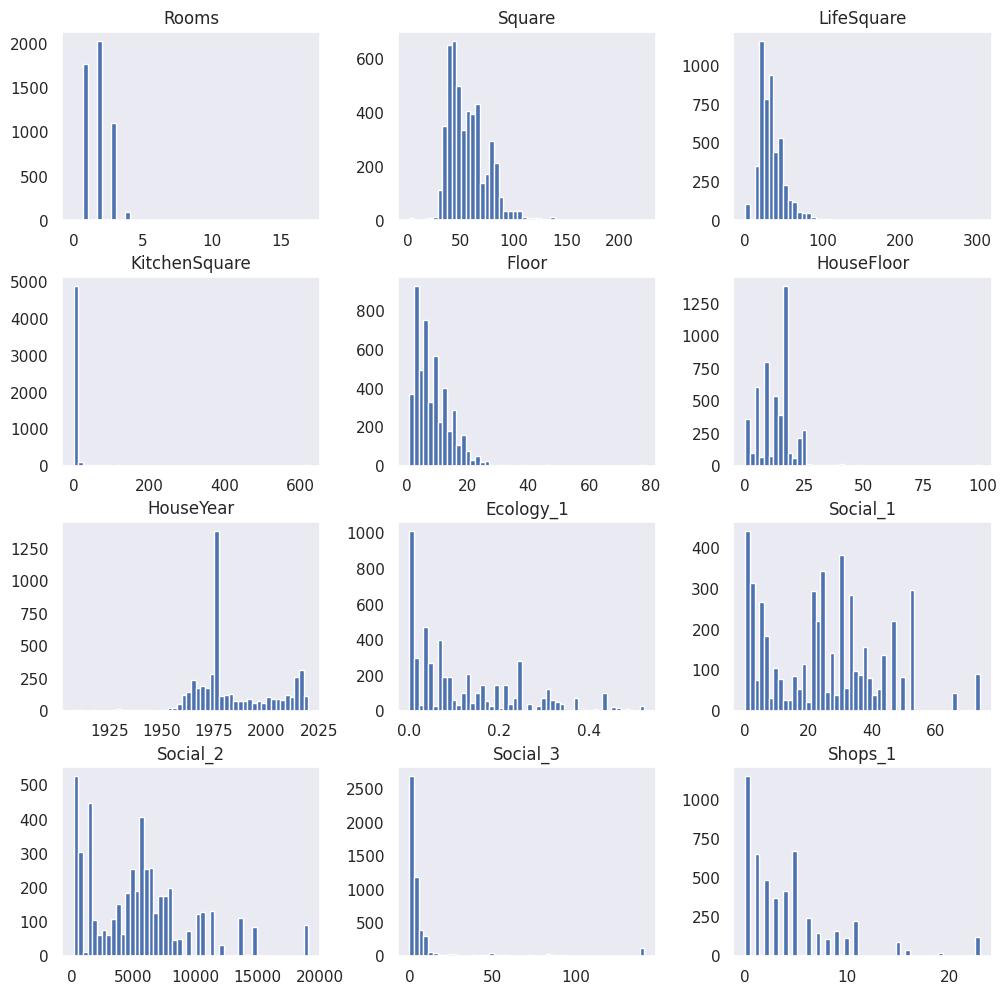

In [75]:
df2_num_features.hist(figsize=(12,12), bins=50, grid=False)
plt.show()

Обработаем выбросы в площадях, этажах. Рейтинги оставим не тронутыми, т.к. не знаем что они значат и в каком виде.

In [76]:
df2[(df2['Square'] > 300) | (df2['Square'] < 15)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
131,16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
571,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
996,2138,27,1.0,5.647458,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1672,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
2051,10120,6,1.0,5.100672,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
2463,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
3042,15435,21,1.0,13.305531,9.495367,0.0,6,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B
3166,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3608,1165,27,1.0,2.372101,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4193,7855,6,1.0,4.967143,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B


In [77]:
df2.loc[df2['Square'] < 15, 'Square'] = df2['Square'].mean()

In [78]:
df2['KitchenSquare'].value_counts()

1.0      1191
5.0       612
8.0       606
6.0       595
10.0      558
9.0       417
0.0       335
7.0       297
12.0      132
11.0      107
13.0       33
4.0        21
14.0       20
15.0       17
16.0       13
3.0        11
17.0        5
2.0         4
42.0        3
18.0        3
19.0        2
20.0        2
97.0        1
112.0       1
65.0        1
620.0       1
24.0        1
44.0        1
40.0        1
60.0        1
57.0        1
41.0        1
34.0        1
30.0        1
62.0        1
61.0        1
33.0        1
22.0        1
Name: KitchenSquare, dtype: int64

In [79]:
df2[(df2['KitchenSquare'] / df2['Square']) > 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
337,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,B,B,31,6119,4,NaN,1,2,B
3332,3194,29,2.0,43.926987,31.028707,44.0,6,5.0,1964,0.086885,B,B,10,2277,2,1547.0,0,0,B
3750,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,B,B,28,6533,1,1015.0,2,5,B
4342,12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B


In [80]:
df2.loc[(df2['KitchenSquare'] / df2['Square']) > 1,  'KitchenSquare'] = df2['KitchenSquare'].median()

In [81]:
df2['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [82]:
df2[(df2['Rooms'] == 0) | (df2['Rooms'] >= 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
961,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
1981,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B
4179,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [83]:
df2.loc[(df2['Rooms'] == 0) | (df2['Rooms'] >= 10), 'Rooms'] = df2['Rooms'].median()

In [84]:
df2['HouseFloor'].value_counts()

17.0    1151
9.0      724
5.0      550
12.0     526
14.0     344
16.0     235
1.0      230
22.0     193
25.0     179
0.0      131
24.0      98
8.0       72
3.0       69
10.0      64
4.0       58
19.0      51
15.0      49
20.0      48
18.0      44
6.0       35
7.0       28
2.0       26
23.0      22
13.0      13
11.0      11
21.0       9
40.0       9
27.0       5
30.0       5
26.0       4
48.0       3
39.0       2
28.0       2
37.0       2
32.0       2
99.0       1
31.0       1
33.0       1
34.0       1
29.0       1
36.0       1
Name: HouseFloor, dtype: int64

In [85]:
df2.loc[df2['HouseFloor'] == 99, 'HouseFloor'] = df2['HouseFloor'].mode()[0]

In [86]:
df2[df2['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
52,15989,62,1.0,47.095406,20.665997,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
61,12694,27,3.0,83.670032,46.358356,0.0,8,0.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
93,6257,62,1.0,43.835919,19.235697,0.0,9,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
95,902,27,3.0,99.293191,43.570976,0.0,2,0.0,1977,0.075424,B,B,11,3097,0,NaN,0,0,B
164,2559,23,2.0,73.868460,32.414316,0.0,9,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,6187,45,3.0,79.798209,35.016357,0.0,17,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
4817,11475,27,1.0,53.263561,23.372653,0.0,9,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4928,13900,169,1.0,48.530248,21.295622,0.0,8,0.0,1977,0.178917,B,B,18,3594,4,192.0,1,5,B
4951,113,27,2.0,65.548249,35.071278,0.0,17,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [87]:
df2.loc[df2['HouseFloor'] == 0, 'HouseFloor'] = df2.loc[df2['HouseFloor'] == 0, 'Floor'] + 1

In [88]:
df2['Social_3'].value_counts()

0      1470
1       896
3       540
4       444
2       323
6       214
5       201
141     120
9       116
11       96
7        92
10       85
8        77
14       53
16       46
48       36
84       32
27       22
24       20
56       19
39       17
23       14
93       12
19       12
59       11
87       10
73        9
20        6
45        5
37        2
Name: Social_3, dtype: int64

In [89]:
df2['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [90]:
df2['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [91]:
df2['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [92]:
df2 = pd.concat([df2, pd.get_dummies(df2['Ecology_2'], prefix='Ecology_2'), pd.get_dummies(df2['Ecology_3'], prefix='Ecology_3'), pd.get_dummies(df2['Shops_2'], prefix='Shops_2')], axis=1)
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1036.0,1,1,B,0,1,0,1,0,1
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,NaN,0,0,A,0,1,0,1,1,0
2,960,27,2.0,59.463678,26.093335,9.0,19,19.0,1977,0.211401,...,NaN,0,1,B,0,1,0,1,0,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,NaN,0,0,B,0,1,0,1,0,1
4,746,74,1.0,53.837056,23.624309,1.0,8,17.0,1977,0.309479,...,990.0,0,6,B,0,1,0,1,0,1


In [93]:
df2.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Ecology_2_A', 'Ecology_2_B',
       'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [94]:
df2.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [95]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
                 'Shops_1','Shops_2_A', 'Shops_2_B']

In [96]:
df2_id = pd.DataFrame(df2['Id'], columns=['Id'])
df2 = df2[feature_names]
df2.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,0,1,0,1,24,4378,0,1,1,0,1
1,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,0,1,0,1,2,629,1,0,0,1,0
2,27,2.0,59.463678,26.093335,9.0,19,19.0,1977,0.211401,0,1,0,1,9,1892,0,0,1,0,1
3,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,0,1,0,1,2,475,0,0,0,0,1
4,74,1.0,53.837056,23.624309,1.0,8,17.0,1977,0.309479,0,1,0,1,35,7715,4,0,6,0,1


### Расчет цены

In [97]:
y_preds = rf_model.predict(df2)
y_preds = pd.DataFrame(y_preds, columns=['Price'])
y_preds

,Price
0,160960.914439
1,123180.947022
2,142140.043786
3,118443.316438
4,194740.607087
...,...
4995,183344.048758
4996,380907.957719
4997,147784.277256
4998,184103.664439


In [98]:
result = pd.concat([df2_id, y_preds], axis=1, ignore_index=False)
result

,Id,Price
0,4567,160960.914439
1,5925,123180.947022
2,960,142140.043786
3,3848,118443.316438
4,746,194740.607087
...,...,...
4995,10379,183344.048758
4996,16138,380907.957719
4997,3912,147784.277256
4998,5722,184103.664439


### Сохранение результатов

In [99]:
result.to_csv('predictions.csv', index=False, encoding='utf-8')

### Выводы

Мы проанализировали имеющиеся данные по цена на недвижимость, обработали и подготовили эти данные. Обучили несколько моделей предсказания, определили лучшую модель и лучшие параметры. Сделали предсказание цены на новых данных.